# Price Trajectories for Cryptos

In [61]:
#Libraries
import pandas as pd
import numpy as np
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.optimize import Bounds
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
from arch.univariate import EWMAVariance,ZeroMean

In [62]:
#Load daily historical series
btc_d = pd.read_excel('USDCoin.xlsx', sep=',',index_col=[0], parse_dates=True)

In [63]:
btc_d.tail()

,RETORNOS,VOLUMEN,PRECIO
DATES,,,
2021-02-22,0.000129,3584165265,1.000074
2021-02-23,0.000147,4522385569,1.000221
2021-02-24,0.000008,2427751206,1.000229
2021-02-25,-0.000157,2301651550,1.000072
2021-02-26,-0.000099,2219159296,0.999973


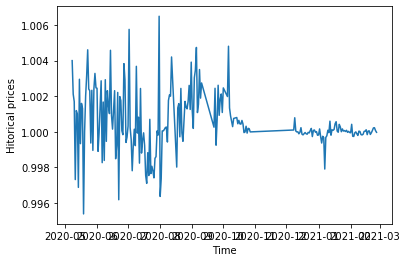

In [64]:
plt.plot(btc_d.index, btc_d.PRECIO)
plt.xlabel('Time')
plt.ylabel('Hitorical prices')
plt.show()

## Estimate parameter of Ornstein-Uhlenbeck/Vasicek Model for historical data
Let $dX_{t}=(\theta_{1}-\theta_{2}X_{t})dt+\theta_{3}dW_{t}$, $X_{0}=x_{0}>0$, guess solution $x\exp^{\theta_{2}t}$ $\Rightarrow$ by Ito
\begin{align*}
d(X_{t}\exp^{\theta_{2}t})&=& \theta_{2}\exp^{\theta_{2}t} X_{t}dt + \exp^{\theta_{2}t}dX_{t}\\
&=& \exp^{\theta_{2}t} (\theta_{1}dt + \theta_{3}dW_{t})
\end{align*}
\begin{align*}
X_{t}\exp^{\theta_{2}t}&=&x_{0}+\theta_{1}\int_{0}^{t}\exp^{\theta_{2}s}ds+\int_{0}^{t}\theta_{3} \exp^{\theta_{2}s} dW_{s}\\
X_{t}\exp^{\theta_{2}t}&=&x_{0}+\frac{\theta_{1}}{\theta_{2}}(\exp^{\theta_{2}t}-1)++\int_{0}^{t}\theta_{3} \exp^{\theta_{2}s} dW_{s}
\end{align*}
\begin{align*}
X_{t}&=&\frac{\theta_{1}}{\theta_{2}}+(x_{0}-\frac{\theta_{1}}{\theta_{2}})\exp^{-\theta_{2}t}+\theta_{3}\int_{0}^{t}\exp^{-\theta_{2}(t-s)}dW_{s}\\
X_{t} &\sim& N(\frac{\theta_{1}}{\theta_{2}}+(x_{0}-\frac{\theta_{1}}{\theta_{2}})\exp^{-\theta_{2}t}, \frac{\theta_{3}^{2}(1- \exp^{-2\theta_{2}t})}{2\theta_{2}})
\end{align*}
Normal distribution
\begin{align*}
p(t,y \mid x_{0}; \mathbf{\theta})&=&\frac{1}{v \sqrt{2 \pi}}\exp(-\frac{(y-m)^{2}}{2v^{2}})
\end{align*}
Find $\mathbf{\theta}$ numerically.

In [65]:
def neg_log_like_OU(y,theta):
    dt = 0.01
    x0 = y[:-1]
    ml= (theta[0]/theta[1])+(x0-(theta[0]/theta[1]))*np.exp(-theta[1]*dt)
    sl= ((theta[2]**2)*(1-np.exp(-2*theta[1]*dt)))/(2*theta[1])
    loglike= np.sum(norm.pdf(y[1:], loc=ml,scale=np.sqrt(sl)))
    return -loglike

In [66]:
neg_log_like_OU(btc_d.PRECIO,(0.5,0.5,0.5))

-1862.145599957621

In [67]:
objective = partial(neg_log_like_OU, btc_d.PRECIO)
bounds = Bounds([-10.0, 0.01, 0.01], [10.0, 2.0, 10.0])

In [68]:
# Actually do the minimization
result = scipy.optimize.minimize(objective, (1,0.5,1), method='trust-constr', bounds=bounds)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

theta MLE: [2.0038623  1.99999455 0.01      ]


## Simulate Ornstein-Uhlenbeck
From the SDE of the process
\begin{equation*}
dX_{t}=(\theta_{1}-\theta_{2}X_{t})dt+\theta_{3}dW_{t}
\end{equation*}
We can obtain an Euler (discrete) approximation 
the we can simulate teh values of $X_{t}$ for $t=1,\ldots,T$
\begin{equation*}
X_{t+1}= X_{t} + (\theta_{1}-\theta_{2}X_{t})(t+1-t)+\theta_{3}\sqrt{t+1-t} Z_{t+1}
\end{equation*}
where $Z_{1},\ldots,Z_{T}$ are independent standard normals. To be consistent with the mean reversion of the process we suggest to set $\theta_{1}=\theta_{2}$ so the long term value is equal to $1.0$ which is the case of Stablecoins.

In [69]:
def sim_OU(S0,Llev,mu,sigma,dt,T):
    Z=np.random.normal(loc=0.0, scale=1, size=T)
    y = np.ndarray(T)
    y[0]=S0
    for t in range(1, T):
        y[t] = y[t-1]+(Llev-mu*y[t-1])*dt+sigma*np.sqrt(dt)*Z[t]
    return y

In [70]:
path1=sim_OU(1,theta_mle[0],theta_mle[1],theta_mle[2],0.01,100)

In [71]:
path1

array([1.        , 0.99950744, 1.00004282, 1.00048973, 0.99979423,
       0.99844468, 0.99922728, 0.99968419, 0.99894768, 0.99848694,
       0.99724623, 0.99765171, 0.997105  , 0.99620295, 0.99755573,
       0.99707156, 0.99750417, 0.999921  , 0.99958642, 0.99865243,
       0.99894216, 0.99954529, 0.99960498, 1.00017574, 1.001736  ,
       1.00069727, 1.00116212, 1.00156923, 1.00228533, 1.00282822,
       1.00259505, 1.00247215, 1.00311957, 1.00192   , 1.0013865 ,
       1.00254636, 1.00327299, 1.00451737, 1.00386869, 1.00543874,
       1.0047487 , 1.00632085, 1.00557741, 1.00662419, 1.00504486,
       1.0058022 , 1.0050244 , 1.00495376, 1.0067169 , 1.00734516,
       1.00844996, 1.01010032, 1.00888351, 1.0073711 , 1.0064522 ,
       1.00753212, 1.0074966 , 1.00635894, 1.00718664, 1.0071339 ,
       1.00672274, 1.00678181, 1.00726339, 1.00581624, 1.00558163,
       1.00467817, 1.00451158, 1.00485655, 1.00584985, 1.00594121,
       1.00736512, 1.00925127, 1.00856662, 1.00938453, 1.00917

In [ ]:
path2=sim_OU(1,0.5,0.5,0.05,0.01,100)

In [ ]:
path2

In [72]:
Nsim=120
paths=pd.DataFrame(columns=range(Nsim))
for i in range(Nsim):
    paths.iloc[:,i]=sim_OU(1,theta_mle[0],theta_mle[1],theta_mle[2],0.01,100)
    #paths.iloc[:,i]=sim_OU(1,0.5,0.5,0.05,0.01,100)

In [73]:
paths.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000725,1.001404,0.999545,1.000249,1.001222,1.001141,1.000613,0.999176,1.000243,1.000448,...,0.999183,1.001237,1.000790,0.999082,1.000602,0.999660,1.001003,0.999595,1.000387,1.001132
2,1.000394,1.000852,0.999574,0.999251,1.001837,0.999363,1.001010,0.999843,1.000432,1.000637,...,1.000575,1.000469,0.999783,0.998982,1.003037,1.000685,1.001453,0.998836,1.000003,1.001253
3,1.000245,1.000110,0.998486,0.996327,1.002927,0.999353,1.001725,0.999681,0.999770,1.000772,...,0.999175,1.000446,0.999861,0.998915,1.003142,1.000903,0.999828,0.998448,1.000696,1.001505
4,0.999562,0.999824,0.997577,0.997037,1.003230,0.999608,1.003494,0.998841,0.999393,1.001752,...,1.000746,0.998416,0.997556,0.999302,1.003466,0.998827,0.998616,0.999576,1.000704,1.000413


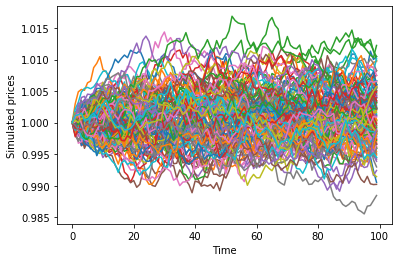

In [74]:
#simulated prices
plt.plot(range(100), paths)
plt.xlabel('Time')
plt.ylabel('Simulated prices')
plt.show()

## Time varying Volatility GARCH(1,1) where EWMA is a particular case

Let $\lambda \in (0,1)$ denote the strenght of autocorrelation in volatility process.
\begin{equation*}
\sigma_{t}^{2} =\lambda\sigma_{t-1}^{2}+(1-\lambda)r_{t-1}^{2}
\end{equation*}
Volatility estimate for day $t$ is given by: the previous estimate $\sigma_{t-1}$ and most recent change in the return process $r_{t-1}$.

In [ ]:
#Log Returns
ret=np.log(btc_d.PRECIO).diff(periods=1)*100
ret=ret[1:]

In [ ]:
plt.plot(btc_d.index[1:], ret)
plt.xlabel('Time')
plt.ylabel('Hitorical returns')
plt.show()

In [ ]:
ret0=ZeroMean(ret)
ret0.volatility=EWMAVariance(lam=0.95)
ewma=ret0.fit()

In [ ]:
daily_std=np.sqrt(ewma.conditional_volatility/100)#*np.sqrt(252) #yealy

In [ ]:
plt.plot(daily_std.index, daily_std)
plt.xlabel('Time')
plt.ylabel('EWMA std (daily)')
plt.show()

In [ ]:
daily_std.describe()